# Plot a Description of the Liquid Precip Estimation Method

## Imports

In [1]:
import glob
import os
import datetime

import numpy as np
import matplotlib.pyplot as plt
import pyart
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.dates import DateFormatter
import pandas as pd
import geopandas as gpd
from metpy.plots import USCOUNTIES
from matplotlib.colors import ListedColormap
from datetime import datetime
import act
import fiona
import numpy as np
from math import atan2 as atan2
fiona.drvsupport.supported_drivers['lib?kml'] = 'rw' # enable KML support which is disabled by default
fiona.drvsupport.supported_drivers['LIBKML'] = 'rw' # enable KML support which is disabled by default


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



ERROR 1: PROJ: proj_create_from_database: Open of /ccsopen/home/mgrover/mgrover/sail-radar-dev/share/proj failed
/ccsopen/home/mgrover/mgrover/sail-radar-dev/lib/python3.9/site-packages/geopandas/_compat.py:18: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  PANDAS_GE_10 = str(pd.__version__) >= LooseVersion("1.0.0")
/ccsopen/home/mgrover/mgrover/sail-radar-dev/lib/python3.9/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/ccsopen/home/mgrover/mgrover/sail-radar-dev/lib/python3.9/site-packages/geopandas/_compat.py:19: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  PANDAS_GE_11 = str(pd.__version__) >= LooseVersion("1.1.0")
/ccsopen/home/mgrover/mgrover/sail-radar-dev/lib/python3.9/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Versio

## Read in the Data

### Read the Watershed and Instrumentation Locations

In [2]:
east_river = gpd.read_file('data/site-locations/East_River.kml')
splash_locations = gpd.read_file('data/site-locations/SPLASH_Instruments.kml')
amf_sensor_locations = gpd.read_file('data/site-locations/SAIL_Instruments.kml')

### Read in the Raw Radar Data

In [3]:
file_list = sorted(glob.glob("/gpfs/wolf/atm124/proj-shared/sail/202203_glued/xprecipradar_guc_volume_20220314-03*"))
file_list[:10]

['/gpfs/wolf/atm124/proj-shared/sail/202203_glued/xprecipradar_guc_volume_20220314-030359.b1.nc',
 '/gpfs/wolf/atm124/proj-shared/sail/202203_glued/xprecipradar_guc_volume_20220314-030920.b1.nc',
 '/gpfs/wolf/atm124/proj-shared/sail/202203_glued/xprecipradar_guc_volume_20220314-031440.b1.nc',
 '/gpfs/wolf/atm124/proj-shared/sail/202203_glued/xprecipradar_guc_volume_20220314-031959.b1.nc',
 '/gpfs/wolf/atm124/proj-shared/sail/202203_glued/xprecipradar_guc_volume_20220314-032520.b1.nc',
 '/gpfs/wolf/atm124/proj-shared/sail/202203_glued/xprecipradar_guc_volume_20220314-033040.b1.nc',
 '/gpfs/wolf/atm124/proj-shared/sail/202203_glued/xprecipradar_guc_volume_20220314-033600.b1.nc',
 '/gpfs/wolf/atm124/proj-shared/sail/202203_glued/xprecipradar_guc_volume_20220314-034120.b1.nc',
 '/gpfs/wolf/atm124/proj-shared/sail/202203_glued/xprecipradar_guc_volume_20220314-034640.b1.nc',
 '/gpfs/wolf/atm124/proj-shared/sail/202203_glued/xprecipradar_guc_volume_20220314-035200.b1.nc']

We can use the first file here, closes to 0300 UTC on March 14, 2022

In [4]:
radar = pyart.io.read(file_list[0])
radar

### Read in the Processed Radar Data Subset for the Different Instruments

```{warning}
Make sure to run the "`csu-xband-snowfall-march-14-2022`" notebook before running this!
```

In [5]:
ds = xr.open_dataset("sail_snowfall_retrievals_march_14_2022.nc")

### Download + Read Rain Gauge and Pluvio and Laser Disdrometer Data

In [6]:
arm_username = "mgrover4"
arm_token = "176e1559b67be630"
start_date = "2022-03-14"
end_date = "2022-03-14"

# Access the laser disdrometer data
laser_disdrometer_files = act.discovery.download_data(username=arm_username,
                                                      token=arm_token,
                                                      datastream="gucldM1.b1",
                                                      startdate=start_date,
                                                      enddate=end_date,
                                                      output="data/laser-disdrometer/")

# Read the laser disdrometer data into an xarray dataset
laser_disdrometer_ds = xr.open_mfdataset(laser_disdrometer_files)

# Access the laser disdrometer data
pluvio_files = act.discovery.download_data(username=arm_username,
                                       token=arm_token,
                                       datastream="gucwbpluvio2M1.a1",
                                       startdate=start_date,
                                       enddate=end_date,
                                       output="data/pluvio/")

# Read the pluvio files into an xarray dataset
pluvio_ds = xr.open_mfdataset(pluvio_files)

[DOWNLOADING] gucldM1.b1.20220314.000000.cdf
[DOWNLOADING] gucwbpluvio2M1.a1.20220314.000000.nc


### Apply QC Flags to both precip rates

In [7]:
disdrometer_precip_rate = laser_disdrometer_ds.where(laser_disdrometer_ds.qc_precip_rate == 0).precip_rate.compute()
gauge_precip_rate = pluvio_ds.where(pluvio_ds.pluvio_status == 0).intensity_rtnrt.compute()

## Setup Helper Functions
We need these helper functions to create the scale bar within our figure

In [8]:
def gc_latlon_bear_dist(lat1, lon1, bear, dist):
    """
    Input lat1/lon1 as decimal degrees, as well as bearing and distance from
    the coordinate. Returns lat2/lon2 of final destination. Cannot be
    vectorized due to atan2.
    """
    re = 6371.1  # km
    lat1r = np.deg2rad(lat1)
    lon1r = np.deg2rad(lon1)
    bearr = np.deg2rad(bear)
    lat2r = np.arcsin((np.sin(lat1r) * np.cos(dist/re)) +
                      (np.cos(lat1r) * np.sin(dist/re) * np.cos(bearr)))
    lon2r = lon1r + atan2(np.sin(bearr) * np.sin(dist/re) *
                          np.cos(lat1r), np.cos(dist/re) - np.sin(lat1r) *
                          np.sin(lat2r))
    return np.rad2deg(lat2r), np.rad2deg(lon2r)
 
    
def add_scale_line(scale, ax, projection, color='k',
                  linewidth=None, fontsize=None, fontweight=None):
    """
    Adds a line that shows the map scale in km. The line will automatically
    scale based on zoom level of the map. Works with cartopy.
 
    Parameters
    ----------
    scale : scalar
        Length of line to draw, in km.
    ax : matplotlib.pyplot.Axes instance
        Axes instance to draw line on. It is assumed that this was created
        with a map projection.
    projection : cartopy.crs projection
        Cartopy projection being used in the plot.
 
    Other Parameters
    ----------------
    color : str
        Color of line and text to draw. Default is black.
    """
    frac_lat = 0.1  # distance fraction from bottom of plot
    frac_lon = 0.5  # distance fraction from left of plot
    e1 = ax.get_extent()
    center_lon = e1[0] + frac_lon * (e1[1] - e1[0])
    center_lat = e1[2] + frac_lat * (e1[3] - e1[2])
    # Main line
    lat1, lon1 = gc_latlon_bear_dist(
        center_lat, center_lon, -90, scale / 2.0)  # left point
    lat2, lon2 = gc_latlon_bear_dist(
        center_lat, center_lon, 90, scale / 2.0)  # right point
    if lon1 <= e1[0] or lon2 >= e1[1]:
        warnings.warn('Scale line longer than extent of plot! ' +
                      'Try shortening for best effect.')
    ax.plot([lon1, lon2], [lat1, lat2], linestyle='-',
            color=color, transform=projection, 
            linewidth=linewidth)
    # Draw a vertical hash on the left edge
    lat1a, lon1a = gc_latlon_bear_dist(
        lat1, lon1, 180, frac_lon * scale / 20.0)  # bottom left hash
    lat1b, lon1b = gc_latlon_bear_dist(
        lat1, lon1, 0, frac_lon * scale / 20.0)  # top left hash
    ax.plot([lon1a, lon1b], [lat1a, lat1b], linestyle='-',
            color=color, transform=projection, linewidth=linewidth)
    # Draw a vertical hash on the right edge
    lat2a, lon2a = gc_latlon_bear_dist(
        lat2, lon2, 180, frac_lon * scale / 20.0)  # bottom right hash
    lat2b, lon2b = gc_latlon_bear_dist(
        lat2, lon2, 0, frac_lon * scale / 20.0)  # top right hash
    ax.plot([lon2a, lon2b], [lat2a, lat2b], linestyle='-',
            color=color, transform=projection, linewidth=linewidth)
    # Draw scale label
    ax.text(center_lon, center_lat - frac_lat * (e1[3] - e1[2]) / 4.0,
            str(int(scale)) + ' km', horizontalalignment='center',
            verticalalignment='center', color=color, fontweight=fontweight,
            fontsize=fontsize)

## Plot the Reflectivity with the Pluvio Sensor and Watershed Locations

/tmp/ipykernel_57/1384334602.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.set_ticklabels(np.arange(-20, 50, 10), fontsize=14)
/ccsopen/home/mgrover/mgrover/sail-radar-dev/lib/python3.9/site-packages/geopandas/plotting.py:74: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if mpl >= LooseVersion("3.4") or (mpl > LooseVersion("3.3.2") and "+" in mpl):
/ccsopen/home/mgrover/mgrover/sail-radar-dev/lib/python3.9/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/ccsopen/home/mgrover/mgrover/sail-radar-dev/lib/python3.9/site-packages/geopandas/plotting.py:74: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if mpl >= LooseVersion("3.4") or (mpl > LooseVersion("3.3.2") and "+" in mpl):
/ccsopen/home/mgrover/mgrover/sail-radar-dev/lib/p

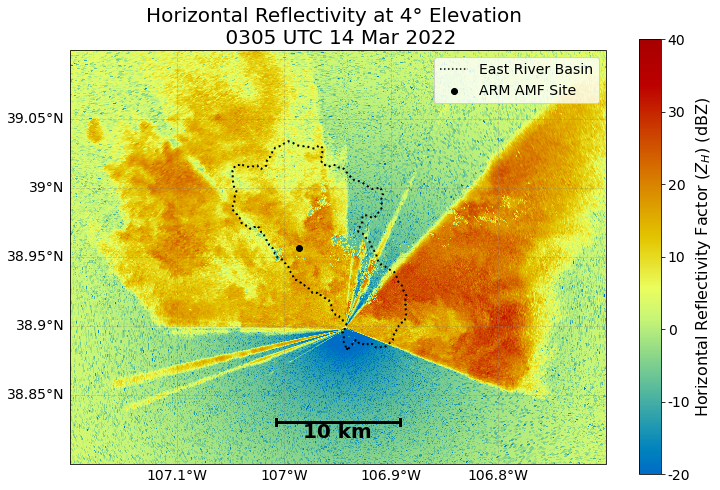

In [38]:
fig = plt.figure(figsize=(12,8))

ax = plt.subplot(111,
                 projection=ccrs.PlateCarree())

min_lat = 38.8
max_lat = 39.1
min_lon = -107.2
max_lon = -106.7

#Setup a RadarMapDisplay, which gives our axes in lat/lon
display = pyart.graph.RadarMapDisplay(radar)
    
# Add our reflectivity (DBZ) field to the plot, including our gatefilter
radar_plot = display.plot_ppi_map('DBZ',
                                  2,
                                  ax=ax,
                                  vmin=-20,
                                  min_lat=min_lat,
                                  max_lat=max_lat,
                                  min_lon=min_lon,
                                  max_lon=max_lon,
                                  embelish=False,
                                  colorbar_label="Horizontal Reflectivity Factor ($Z_{H}$) \n (dBZ)",
                                  vmax=40.,)

cbar = display.cbs[0]
cbar.set_ticklabels(np.arange(-20, 50, 10), fontsize=14)
cbar.set_label(label='Horizontal Reflectivity Factor ($Z_{H}$) (dBZ)', fontsize=16)

display.cbs = [cbar]


east_river.plot(ax=ax,
                linewidth=2,
                edgecolor='k',
                facecolor="None",
                linestyle=':',)

ax.plot(0,
        0,
        color='k',
        linestyle=':',
        label='East River Basin')

amf_sensor_locations.loc[amf_sensor_locations.Name == 'PLUVIO'].plot(ax=ax,
                                                                     color='k',
                                                                     label='ARM AMF Site')

plt.legend(loc='upper right',
           fontsize=14)

plt.xlim(min_lon, max_lon)
plt.ylim(min_lat, max_lat)

# Add our scale bar
add_scale_line(10.0, ax, projection=ccrs.PlateCarree(), 
               color='black', linewidth=3,
               fontsize=20,
               fontweight='bold')

# Add gridlines
gl = ax.gridlines(crs=ccrs.PlateCarree(),
                   draw_labels=True,
                   linewidth=1, 
                   color='gray', 
                   alpha=0.3,
                   linestyle='--')

plt.gca().xaxis.set_major_locator(plt.NullLocator())

# Make sure labels are only plotted on the left and bottom
gl.xlabels_top = False
gl.ylabels_right = False

gl.xlabel_style = {'size': 14}
gl.ylabel_style = {'size': 14}

third_sweep = radar.extract_sweeps([2])
time = pd.to_datetime(third_sweep.time["data"], unit='s').mean()
time_in_label = time.strftime("%H%M UTC %d %b %Y")

plt.title(f"Horizontal Reflectivity at 4° Elevation \n {time_in_label}", fontsize=20)

plt.savefig("ppi_4deg_march14_0300.png", dpi=300, bbox_inches="tight")

plt.show()

## Plot a Timeseries of Reflectivity and Snowfall at the Pluvio Sensor

/tmp/ipykernel_57/3408333344.py:103: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.set_ticklabels(np.arange(-20, 50, 10), fontsize=14)


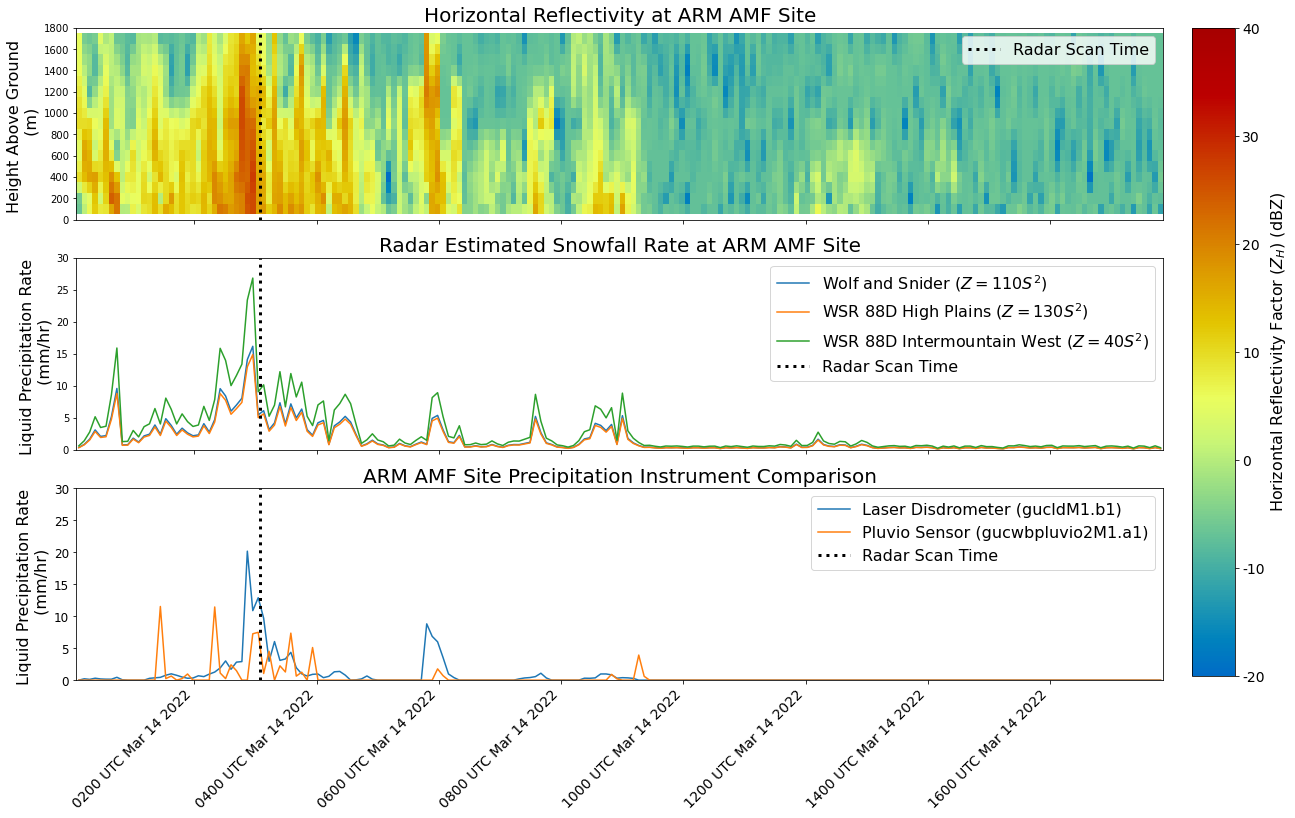

In [37]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, sharey=False, figsize=(20,12))


ds_at_site = ds.sel(site="pluvio").dropna(dim='height')

date_form = DateFormatter("%H%M UTC %b %d %Y")

dbz_plot = ds.sel(site='pluvio').DBZ.plot(cmap='pyart_HomeyerRainbow',
                                      vmin=-20,
                                      vmax=40,
                                       ax=ax1,
                                       add_colorbar=False,
                                      figure=fig,
                                      x='time')



ax1.set_ylim(0, 1800)
ax1.set_ylabel("Height Above Ground \n (m)", fontsize=16)
ax1.set_xlabel("")

ax1.set_title(f'Horizontal Reflectivity at ARM AMF Site', fontsize=20)



ax1.xaxis.set_major_formatter(date_form)
ax1.axvline(datetime(2022, 3, 14, 3, 5),
            linewidth=3,
            color='k',
            linestyle=':',
            label='Radar Scan Time')

ax1.legend(loc='upper right', fontsize=16)

date_form = DateFormatter("%H%M UTC %b %d %Y")

zs_relationship_dict = {"Wolf_and_Snider":
                        {"A": 110,
                         "B": 2},
                        "WSR_88D_High_Plains":
                        {"A": 130,
                         "B": 2},
                        "WSR_88D_Intermountain_West":
                        {"A": 40,
                         "B": 2}
                       }

site_name = ds_at_site.site.values
for relationship in zs_relationship_dict.keys():
    relationship_name = relationship.replace("_", " ")
    a_coefficeint = ds[relationship].A
    b_coefficeint = ds[relationship].B
    relationship_equation = f"$Z = {a_coefficeint}S^{b_coefficeint}$"

    ds_at_site.isel(height=0)[relationship].plot(label=f'{relationship_name} ({relationship_equation})',
                                                 ax=ax2)
    ax2.xaxis.set_major_formatter(date_form)



ax2.set_title(f"Radar Estimated Snowfall Rate at ARM AMF Site", fontsize=20)

ax2.axvline(datetime(2022, 3, 14, 3, 5),
            linewidth=3,
            color='k',
            linestyle=':',
            label='Radar Scan Time')

ax2.legend(loc='upper right', fontsize=16)
ax2.set_xlabel("")
ax2.set_ylabel("Liquid Precipitation Rate \n (mm/hr)", fontsize=16)
ax2.set_ylim(0, 30)

# Instrument Intercomparison

disdrometer_precip_rate.interp(time=ds.time).plot(ax=ax3,
                                                  label= f"Laser Disdrometer ({laser_disdrometer_ds.datastream})",
                                                 )

gauge_precip_rate.interp(time=ds.time).plot(ax=ax3,
                                            label=f"Pluvio Sensor ({pluvio_ds.datastream})",
                                           )

ax3.set_title(f"ARM AMF Site Precipitation Instrument Comparison", fontsize=20)

ax3.xaxis.set_major_formatter(date_form)
ax3.axvline(datetime(2022, 3, 14, 3, 5),
            linewidth=3,
            color='k',
            linestyle=':',
            label='Radar Scan Time')

plt.legend(loc='upper right', fontsize=16)
plt.xlabel("")
plt.ylabel("Liquid Precipitation Rate \n (mm/hr)", fontsize=16)
plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=12)
plt.ylim(0, 30)

fig.subplots_adjust(right=0.88)
cbar_ax = fig.add_axes([0.9, 0.13, 0.03, 0.75])
cbar = fig.colorbar(dbz_plot, orientation="vertical", ax=ax1, cax=cbar_ax)
cbar.set_ticklabels(np.arange(-20, 50, 10), fontsize=14)
cbar.set_label(label='Horizontal Reflectivity Factor ($Z_{H}$) (dBZ)', fontsize=16)
plt.savefig("ppi_precip_estimate_pluvio.png", bbox_inches="tight", dpi=300)